# Song lyrics exploration - Part 2: Lexical diversity

This part explores the [lexical diversity](https://en.wikipedia.org/wiki/Lexical_diversity) of different metal genres and bands. A few different methods are used to quantify lexical diversity in order to answer the question of which genre or band has the most complex vocabulary.

In [24]:
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
plt.style.use('seaborn')
import seaborn as sns
sns.set(font_scale=2)
from nltk.corpus import words as nltk_words
from scipy.optimize import curve_fit
from scipy.stats import hypergeom

import sys
sys.path.append('../scripts/')
from nlp import tokenize

# Loading and pre-processing data

In [16]:
def get_genres(data):
    columns = [col for col in data.columns if 'genre_' in col]
    genres = [re.sub(r"^genre\_", "", col) for col in columns]
    return genres, columns


def get_bands(data):
    genres, genre_cols = get_genres(data)
    # Combine songs from same band
    band_genres = df.groupby('band_name')['band_genre'].first()
    band_labels = data.groupby('band_name')[genre_cols].max()
    band_lyrics = data.groupby('band_name')['song_darklyrics'].sum()
    bands = pd.concat((band_genres, band_labels, band_lyrics), axis=1)
    bands.index.name = 'band'
    bands.columns = ['genre'] + genres + ['lyrics']
    bands['words'] = bands['lyrics'].apply(tokenize)
    return bands


def get_songs(data):
    genres, genre_cols = get_genres(data)
    songs = data[['band_name', 'band_genre', 'song_name'] + genre_cols + ['song_darklyrics']].copy()
    songs.columns = ['band', 'genre', 'song'] + genres + ['lyrics']
    songs['words'] = songs['lyrics'].apply(tokenize)
    return songs

In [4]:
df = pd.read_csv('../songs-10pct.csv')

In [17]:
df_bands = get_bands(df)
df_songs = get_songs(df)

In [20]:
len(df_bands), len(df_songs)

(1355, 58174)

# Lexical diversity measures

One simple approach to quantifying lexical diversity is to divide the number of unique words (types, $V$) by the total word count (tokens, $N$). This type-token ratio or TTR is heavily biased toward short texts, since longer texts are more likely to repeat tokens without necessarily diminishing complexity. A few ways exist for rescaling the relationship to reduce this bias; for this notebook the root-TTR and log-TTR are used:

$$
\begin{split}
&LD_{TTR} &= \frac{V}{N} &\hspace{1cm} (\textrm{type-token ratio})\\
&LD_{rootTTR} &= \frac{V}{\sqrt{N}} &\hspace{1cm} (\textrm{root type-token ratio})\\
&LD_{logTTR} &= \frac{\log{V}}{\log{N}} &\hspace{1cm} (\textrm{logarithmic type-token ratio})\\
\end{split}
$$

### MTLD

More sophisticated approaches look at how types are distributed in the text. The bluntly named Measure of Textual Lexical Diversity (MTLD), described by [McCarthy and Jarvis (2010)](https://doi.org/10.3758/BRM.42.2.381), is based on the mean length of token sequences in the text that exceed a certain TTR threshold. The algorithm begins with a sequence consisting of the first token in the text, and iteratively adds the following token, each time recomputing the TTR of the sequence so far. Once the sequence TTR drops below the pre-determined threshold, the sequence ends and a new sequence begins at the next token. This continues until the end of the text is reached, at which point the mean sequence length is computed. The process is repeated from the last token, going backwards, to produce another mean sequence length. The mean of these two results is the final MTLD figure.

Unlike the simpler methods, MTLD has a tunable parameter. The TTR threshold is chosen by the authors to be 0.720, which is approximately where the cumulative TTR curves for texts in the Project Gutenburg Text Archives reached a point of stabilization. The same can be done with the DarkLyrics data by plotting cumulative TTR values for a large number of bands and identifying the point of stabilization. This cannot be done with single-song lyrics since refrains in the lyrics heavily warp the cumulative TTR curves, such that most never stabilize. Unfortunately even when looking at band lyrics, the cumulative TTR does not stabilize very well, as the curves seem to continue decaying well into the thousands of tokens. However one can roughly identify a point of stabilization somewhere around a TTR of 0.5, occuring at about 200 tokens, so this is used as the threshold for MTLD.

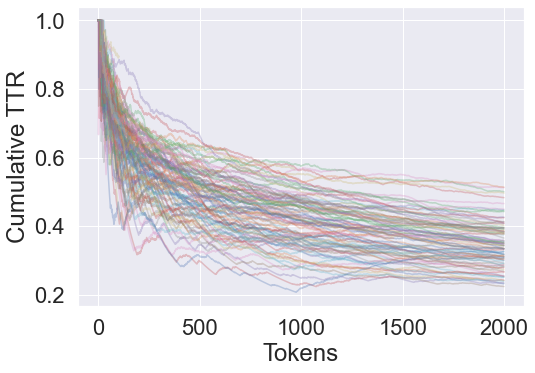

In [21]:
def TTR(x):
    return len(set(x)) / len(x)

def cumulative_TTR(words):
    out = [TTR(words[: i + 1]) for i in range(len(words))]
    return out

for i in range(0, 1000, 10):
    plt.plot(cumulative_TTR(df_bands.iloc[i].words[:2000]), alpha=0.3)
plt.xlabel('Tokens')
plt.ylabel('Cumulative TTR')
plt.show()

In [22]:
def MTLD_forward(words, threshold):
    factor = 0
    segment = []
    i = 0
    while i < len(words):
        segment.append(words[i])
        segTTR = TTR(segment)
        if segTTR <= threshold:
            segment = []
            factor += 1
        i += 1
    if len(segment) > 0:
        factor += (1.0 - segTTR) / (1.0 - threshold)
    factor = max(1.0, factor)
    mtld = len(words) / factor
    return mtld


def MTLD(words, threshold=0.720):
    if len(words) == 0:
        return 0.0
    forward = MTLD_forward(words, threshold)
    reverse = MTLD_forward(words[::-1], threshold)
    return 0.5 * (forward + reverse)

### vocd-D

The *vocd-D* method devised by [Malvern *et al.* (2004)](https://www.palgrave.com/gp/book/9781403902313) computes the mean TTR across 100 samples of lengths 35, 36, ... 49, 50. A function is fit to the resulting TTR vs. sample size data and the extracted best fit parameter $D$ is the lexical diversity index. Since this is a sampling-based method, the routine is done three times and the average of the $D$ values is output. I did not have access to Malvern *et al.* (2004) but did find the relevant function to fit from a [publicly viewable implementation](https://metacpan.org/release/Lingua-Diversity/source/lib/Lingua/Diversity/VOCD.pm) that is cited on a [Text Inspector page](https://textinspector.com/help/lexical-diversity).

$$f_{vocd}(N_s) = \frac{D}{N_s} \left( \sqrt{1 + 2 \frac{N_s}{D}} - 1 \right) \label{vocd-D}\tag{1}$$

where $N_s$ is the sample size. The higher the value of $D$, the more diverse the text.

### HD-D

[McCarthy and Jarvis (2007)](https://doi.org/10.1177%2F0265532207080767) showed that *vocd-D* was merely approximating a result that could directly be computed from the [hypergeometric distribution](https://en.wikipedia.org/wiki/Hypergeometric_distribution). They developed an alternate implementation *HD-D* that computes the mean TTR for each sample size by summing the contribution of each type in the text to the overall mean TTR. The contribution of a type $t$ for a given sample size $N_s$ is equal to the product of that type's TTR contribution ($1/N_s$) and the probability of finding at least one instance of type $t$ in any sample. This probability is one minus the probability of finding exactly zero instances of $t$ in any sample, which can be computed by the hypergeometric distribution $P_t(k_t=0, N, n_t, N_s)$, where $k_t$ is the number of instances of type $t$, $N$ is still the number of tokens in the text, and $n_t$ is the number of occurences of $t$ in the full text (the order of arguments here is chosen to match the input of [`scipy.stats.hypergeom`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.hypergeom.html) rather than the example in McCarthy and Jarvis (2007)). Thus, in summary, the goal is to compute

$$ f_{HD}(N_s) = \frac{1}{N_s} \sum_{t=1}^{V} 1 - P_t(0, N, n_t, N_s) \label{HD-D}\tag{2}$$

and either equate this to the Eq. \ref{vocd-D} above and [solve](https://www.symbolab.com/solver/function-inverse-calculator/inverse%20f%5Cleft(x%5Cright)%3Dx%5Cleft(%5Csqrt%7B%5Cleft(1%2B%5Cfrac%7B2%7D%7Bx%7D%5Cright)%7D-1%5Cright)) for $D$:

$$ D(N_s) = -\frac{\left[f_{HD}(N_s)\right]^2}{2\left[f_{HD}(N_s)-1\right]} $$

where $x$ is the output of Eq. \ref{HD-D}. The average across all sample sizes gives the value of $D$ for the *HD-D* method. Alternatively one can instead fit Eq. \ref{vocd-D} to the output of Eq. \ref{HD-D} to determine $D$.


### *vocd-D* or *HD-D*?

Although *vocd-D* merely approximates the result of *HD-D*, the latter is much slower, taking several seconds to produce *D* for a single artist's lyrics. The approximate method is still fairly accurate (within <1% away from the *HD-D* result in the example case) with just three trials, so it is the preferred method used in the rest of the notebook.

106.00419502580168


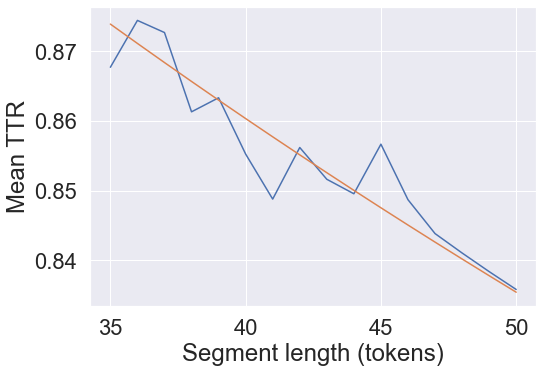

In [25]:
# Example of one vocd-D trial for a single artist

words = df_bands.loc['A Canorous Quintet'].words
num_segs = 100
seglen_range = range(35, 51)
ttrs = np.zeros((len(seglen_range), num_segs))
for i, seglen in enumerate(seglen_range):
    for j in range(num_segs):
        sample = random.sample(words, seglen)
        ttrs[i, j] = TTR(sample)
avg_ttrs_vocdD = ttrs.mean(1)
curve = lambda x, D: (D / x) * (np.sqrt(1 + 2 * (x / D)) - 1)
(D_vocdD,), _ = curve_fit(curve, seglen_range, avg_ttrs_vocdD)
print(D_vocdD)

plt.plot(seglen_range, avg_ttrs_vocdD)
plt.plot(seglen_range, curve(seglen_range, D_vocdD))
plt.xlabel('Segment length (tokens)')
plt.ylabel('Mean TTR')
plt.show()

In [26]:
# vocd-D implementation and example D values

def vocdD_curve(x, D):
    return (D / x) * (np.sqrt(1 + 2 * (x / D)) - 1)

def vocdD(words, num_trials=3, num_segs=100, min_seg=35, max_seg=50):
    if max_seg > len(words):
        return np.nan
    D_trials = []
    seglen_range = range(min_seg, max_seg + 1)
    for _ in range(num_trials):
        ttrs = np.zeros((len(seglen_range), num_segs))
        for i, seglen in enumerate(seglen_range):
            for j in range(num_segs):
                sample = random.sample(words, seglen)
                ttrs[i, j] = TTR(sample)
        avg_ttrs = ttrs.mean(1)
        (D_trial,), _ = curve_fit(vocdD_curve, seglen_range, avg_ttrs)
        D_trials.append(D_trial)
    return np.mean(D_trials)

print(vocdD(df_bands.loc['A Canorous Quintet'].words))
print(vocdD(df_bands.loc['Bal-Sagoth'].words))
print(vocdD(df_bands.loc['Dalriada'].words))

107.36196331404047
100.18942696207353
289.5098775114093


107.01527500420121
107.11834117484182


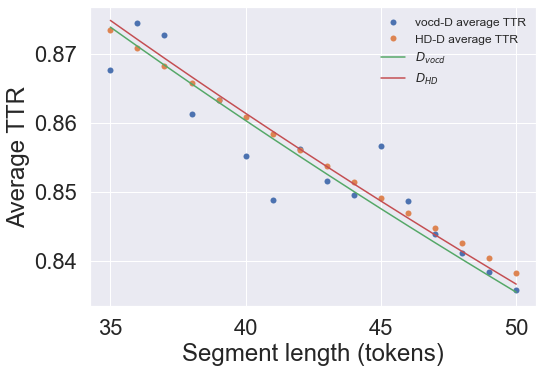

In [28]:
# Example of HD-D for a single artist and comparison to vocd-D

N = len(words)
types = {t: words.count(t) for t in set(words)}
seglen_range_HDD = range(35, 51)
avg_ttrs_HDD = np.zeros(len(seglen_range_HDD))
D_HDDs = np.zeros(len(seglen_range_HDD))
for s, N_s in enumerate(seglen_range_HDD):
    avg_ttr = 0
    for t, n_t in types.items():
        P_t = hypergeom(N, n_t, N_s).pmf(0)
        avg_ttr += (1 - P_t) / float(N_s)
    avg_ttrs_HDD[s] = avg_ttr
    D_HDDs[s] = -N_s * avg_ttr ** 2 / (2 * (avg_ttr - 1))
D_HDD1 = D_HDDs.mean()
print(D_HDD1)
(D_HDD2,), _ = curve_fit(vocdD_curve, seglen_range, avg_ttrs_HDD)
print(D_HDD2)

plt.plot(seglen_range, avg_ttrs_vocdD, 'o', label='vocd-D average TTR')
plt.plot(seglen_range, avg_ttrs_HDD, 'o', label='HD-D average TTR')
plt.plot(seglen_range, vocdD_curve(seglen_range, D_vocdD), label='$D_{vocd}$')
plt.plot(seglen_range, vocdD_curve(seglen_range, np.mean([D_HDD1, D_HDD2])), label='$D_{HD}$')
plt.xlabel('Segment length (tokens)')
plt.ylabel('Average TTR')
plt.legend(fontsize=12)
plt.show()

In [29]:
def get_lexical_diversity(data):
    N = data.words.apply(len)
    V = data.words.apply(lambda x: len(set(x)))
    data['N'] = N
    data['V'] = V
    data['TTR'] = V / N
    data['rootTTR'] = V / np.sqrt(N)
    data['logTTR'] = np.log(V) / np.log(N)
    data['mtld'] = data.words.apply(MTLD, threshold=0.5)
    data['logmtld'] = np.log(data['mtld'])
    data['vocdd'] = data.words.apply(vocdD, num_segs=10)
    return data[data.N > 0]

In [30]:
df_bands = get_lexical_diversity(df_bands)
df_songs = get_lexical_diversity(df_songs)

# Histograms

In [31]:
def plot_histograms(data):
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    fig.suptitle("Lexical diversity of heavy metal artists", fontsize=30)
    axes = axes.flatten()

    ax = axes[0]
    logNmin, logNmax = np.log10(data.N.min()), np.log10(data.N.max())
    logbins = np.logspace(logNmin, logNmax, 20)
    data.N.hist(bins=logbins, edgecolor='k', ax=ax)
    ax.set_xscale('log')
    ax.set_title("Vocabulary sizes")
    ax.set_xlabel("N (tokens)")
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_major_formatter(ScalarFormatter())

    ax = axes[1]
    data.TTR.hist(bins=20, edgecolor='k', ax=ax)
    ax.set_title("Type-token ratio")
    ax.set_xlabel("$\mathrm{LD_{TTR} = V/N}$")

    ax = axes[2]
    data.rootTTR.hist(bins=20, edgecolor='k', ax=ax)
    ax.set_title("Root type-token ratio")
    ax.set_xlabel("$\mathrm{LD_{rootTTR}} = \sqrt{V/N}$")

    ax = axes[3]
    data.logTTR.hist(bins=30, edgecolor='k', ax=ax)
    ax.set_title("Logarithmic type-token ratio")
    ax.set_xlabel("$\mathrm{LD_{logTTR}} = \log V / \log N$")

    ax = axes[4]
    data.logmtld[data.logmtld > -np.inf].hist(bins=30, edgecolor='k', ax=ax)
    ax.set_title("Measure of Textual Lexical Diversity")
    ax.set_xlabel("$\log(\mathrm{MTLD})$")

    ax = axes[5]
    data.vocdd[~data.vocdd.isnull()].hist(bins=30, edgecolor='k', ax=ax)
    ax.set_title("vocd-D")
    ax.set_xlabel("$D_{\mathrm{fit}}$")

    for ax in axes:
        ax.set_ylabel("Artists", rotation=0, labelpad=40)
        ax.grid(None)
        ax.grid(axis='y', color='k')

    fig.tight_layout(rect=[0, 0, 1, 0.95])
    return

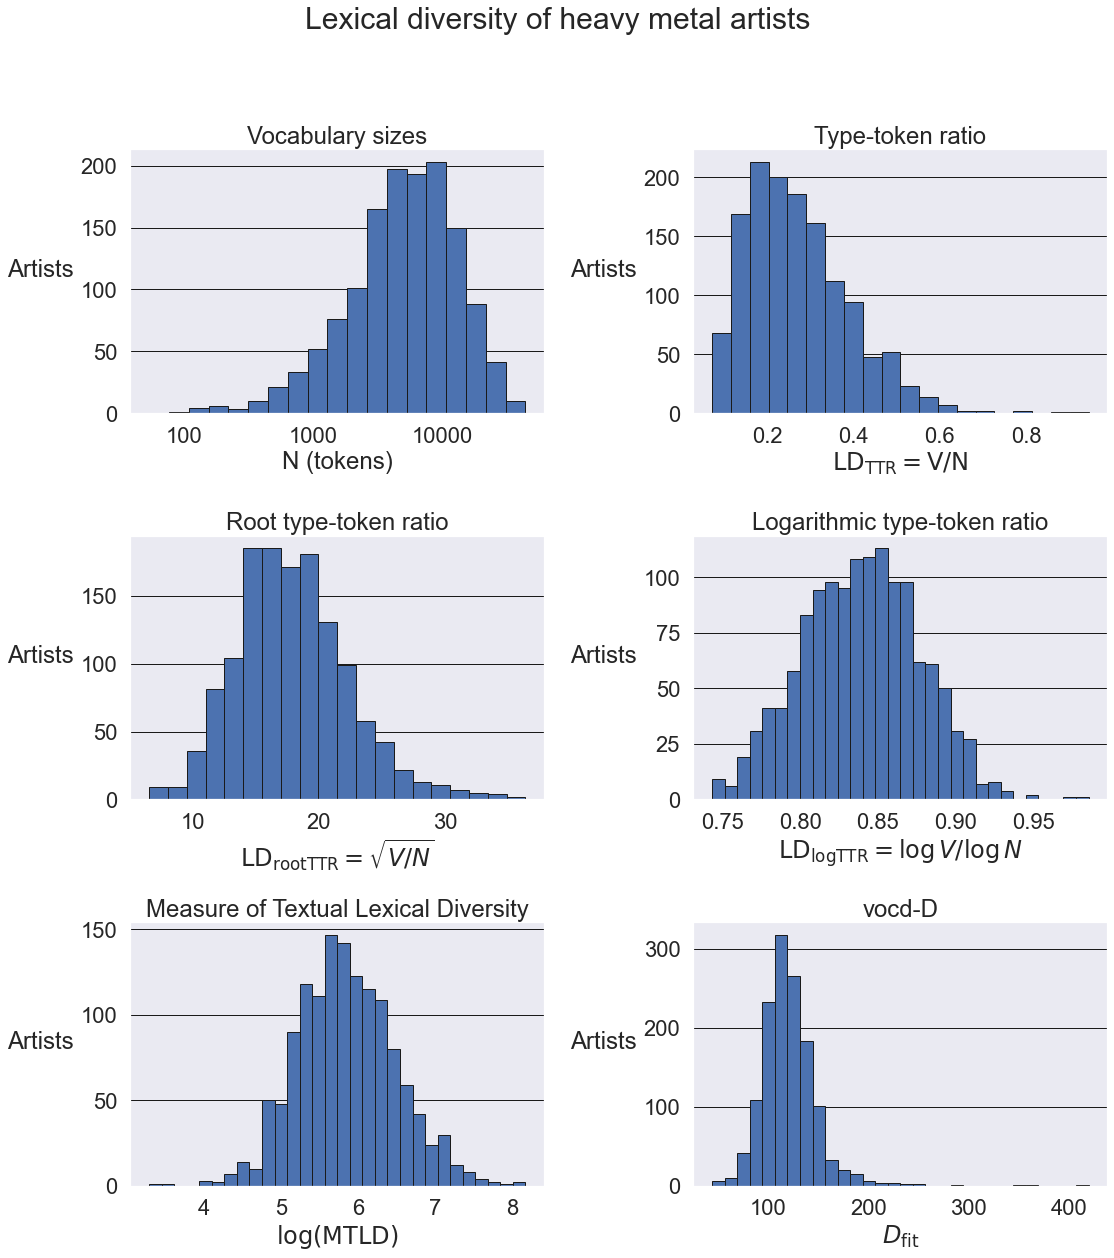

In [32]:
plot_histograms(df_bands)

# Violin plots

In [37]:
def plot_violinplots(data, figsize=(16, 18)):

    def violinplot(col, ax):
        violindata = []
        labels = data.columns[1:list(data.columns).index('lyrics')]
        for label in labels:
            values = data[data[label] == 1][col]
            values = values[(values > -np.inf) & (values < np.inf)]
            violindata.append((label, values))
        violindata.sort(key=lambda x: -x[1].median())
        plot_labels, plot_data = zip(*violindata)
        sns.violinplot(data=plot_data, cut=0, orient='h', ax=ax, color='c')
        ax.set_yticklabels(plot_labels)
        return

    fig, axes = plt.subplots(3, 2, figsize=figsize)
    fig.suptitle("Lexical diversity of artists by genre", fontsize=30)
    axes = axes.flatten()

    ax = axes[0]
    violinplot('N', ax)
    ax.set_title("Word counts")
    ax.set_xlabel("N (tokens)")

    ax = axes[1]
    violinplot('V', ax)
    ax.set_title("Unique word counts")
    ax.set_xlabel("V (types)")

    ax = axes[2]
    violinplot('TTR', ax)
    ax.set_title("Type-token ratio")
    ax.set_xlabel(r"$\mathrm{LD_{TTR}}$")

    ax = axes[3]
    violinplot('logTTR', ax)
    ax.set_title("Logarithmic type-token ratio")
    ax.set_xlabel(r"$\mathrm{LD_{logTTR}}$")

    ax = axes[4]
    violinplot('logmtld', ax)
    ax.set_title("Measure of Textual Lexical Diversity")
    ax.set_xlabel("$\log(\mathrm{MTLD})$")

    ax = axes[5]
    violinplot('vocdd', ax)
    ax.set_title("vocd-D")
    ax.set_xlabel("$D_{\mathrm{fit}}$")

    fig.tight_layout(rect=[0, 0, 1, 0.95])
    return

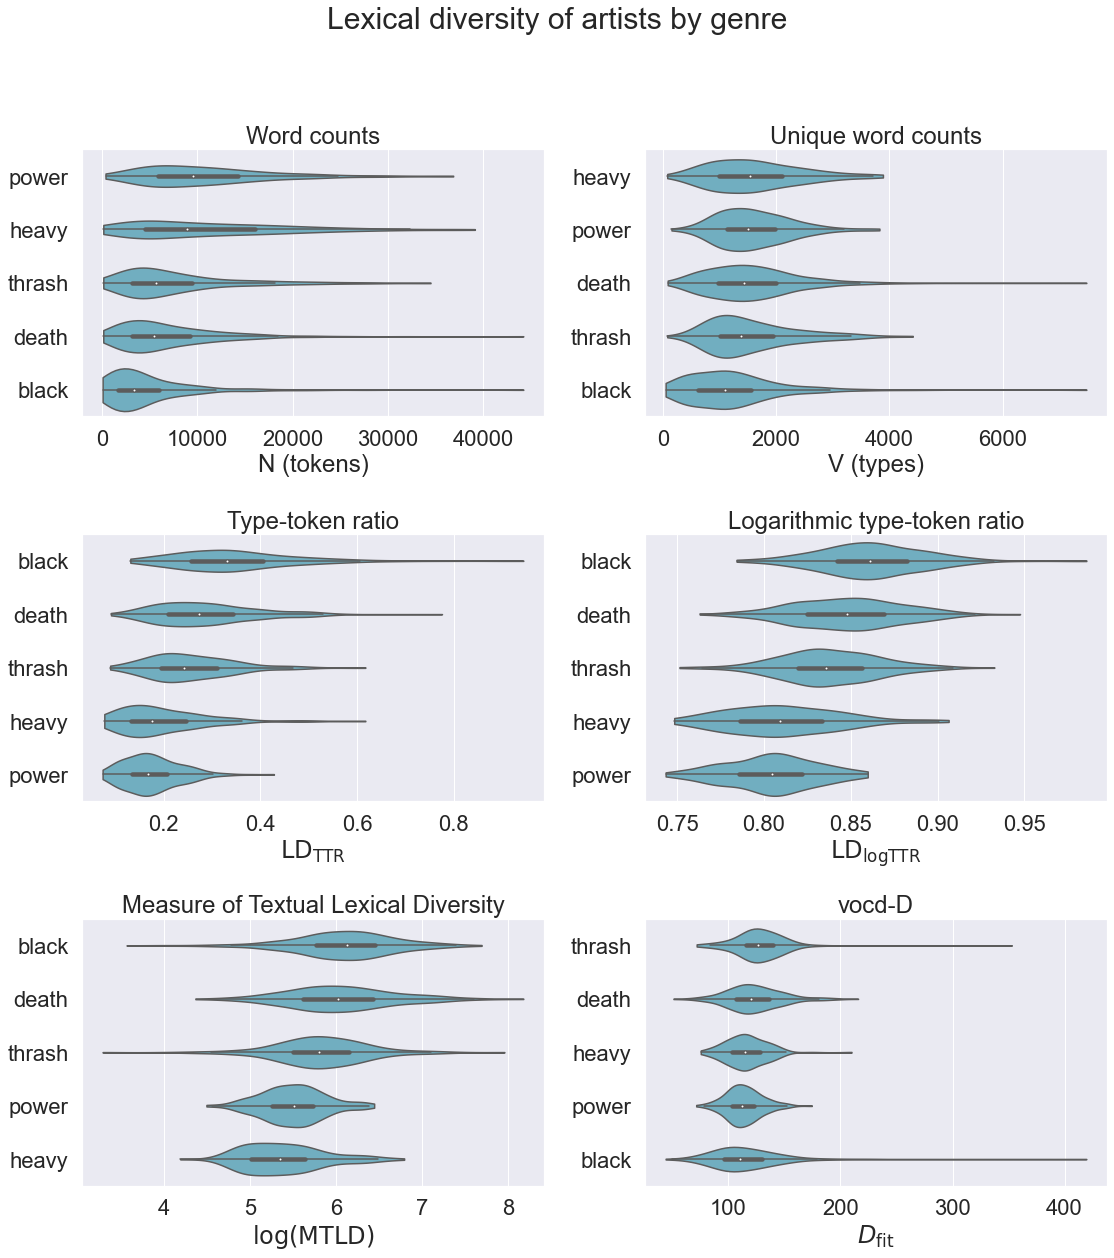

In [38]:
plot_violinplots(df_bands, figsize=(16, 18))

Several of the highest MTLD scores come from Bal-Sagoth songs. These are inflated as discussed in [Part 1](./lyrics0.ipnby): [Bal-Sagoth's lyrics](http://www.darklyrics.com/lyrics/balsagoth/thechthonicchronicles.html#4) consist of entire chapters of prose that are not actually sung in the songs themselves. Apart from this, The song with the highest MTLD is a 6-minute track by the Hungarian folk metal band Dalriada, [Zách Klára](http://www.darklyrics.com/lyrics/dalriada/aranyalbum.html#1).

In [53]:
song_cols = list(df_songs.columns)
song_cols_show = list(df_songs.columns[:song_cols.index('song') + 1]) + list(df_songs.columns[song_cols.index('N'):])

['TTR', 'rootTTR', 'logTTR', 'mtld', 'logmtld', 'vocdd']

In [101]:
pd.options.display.float_format = '{:,.2f}'.format

In [108]:
df_songs.sort_values('mtld', ascending=False).reset_index(drop=True).shift(1).loc[1:10, song_cols_show].convert_dtypes()

,band,genre,song,N,V,TTR,rootTTR,logTTR,mtld,logmtld,vocdd
1,Bal-Sagoth,Symphonic/Epic Black Metal,The Obsidian Crown Unbound,2391,993,0.42,20.31,0.89,914.29,6.82,83.49
2,Bal-Sagoth,Symphonic/Epic Black Metal,Six Score and Ten Oblations to a Malefic Avatar,840,453,0.54,15.63,0.91,840.00,6.73,122.56
3,Dalriada,Folk Metal,Zách Klára,799,467,0.58,16.52,0.92,799.00,6.68,253.69
4,Ulver,"Black/Folk Metal (early), Ambient/Avant-garde/...",Stone Angels,769,418,0.54,15.07,0.91,769.00,6.65,163.42
5,Bal-Sagoth,Symphonic/Epic Black Metal,Summoning the Guardians of the Astral Gate,759,404,0.53,14.66,0.90,759.00,6.63,89.30
6,Dalriada,Folk Metal,Ágnes asszony (1. rész),744,393,0.53,14.41,0.90,744.00,6.61,139.09
7,Bal-Sagoth,Symphonic/Epic Black Metal,To Dethrone the Witch-Queen of Mytos K'unn (Th...,1413,621,0.44,16.52,0.89,741.83,6.61,91.81
8,Bal-Sagoth,Symphonic/Epic Black Metal,Unfettering the Hoary Sentinels of Karnak,1344,627,0.47,17.10,0.89,730.72,6.59,87.07
9,Cradle of Filth,"Death Metal (early), Symphonic Black Metal (mi...",Beneath the Howling Stars,706,426,0.60,16.03,0.92,706.00,6.56,142.68
10,Bal-Sagoth,Symphonic/Epic Black Metal,Blood Slakes the Sand at the Circus Maximus,1280,586,0.46,16.38,0.89,701.02,6.55,110.94


In [109]:
df_songs.sort_values('vocdd', ascending=False).reset_index(drop=True).shift(1).loc[1:10, song_cols_show].convert_dtypes()

,band,genre,song,N,V,TTR,rootTTR,logTTR,mtld,logmtld,vocdd
1,Hail of Bullets,Death Metal,DAK,54,54,1.00,7.35,1.00,54,3.99,"787,177.13"
2,Cenotaph,Brutal Death Metal,Voluptuously Minced,67,66,0.99,8.06,1.00,67,4.20,"2,447.52"
3,Incantation,Death Metal,Invoked Infinity,53,52,0.98,7.14,1.00,53,3.97,"1,460.79"
4,Incantation,Death Metal,Ancients Arise,73,71,0.97,8.31,0.99,73,4.29,"1,100.15"
5,Venom,NWOBHM/Black/Speed Metal,All There Is Fear,78,75,0.96,8.49,0.99,78,4.36,"1,015.47"
6,Cianide,Death/Doom Metal,One-Thousand Ways to Die,97,92,0.95,9.34,0.99,97,4.57,835.13
7,Pessimist,Brutal Death/Black Metal,Psychological Autopsy,88,84,0.95,8.95,0.99,88,4.48,806.54
8,Schizo,Thrash/Black Metal,Mind K,55,53,0.96,7.15,0.99,55,4.01,719.35
9,Autopsy,Death Metal,Ugliness and Secretions,55,53,0.96,7.15,0.99,55,4.01,717.19
10,Judas Priest,Heavy Metal,Solar Angels,52,50,0.96,6.93,0.99,52,3.95,668.13


The bottom of the chart is mostly populated by very short, usually one-word, songs.
Of songs with at least ten words, the honor of least lyrically diverse song goes to
none other than the magnificently linguistically efficient "Thunderhorse" by Dethklok,
which consists of the words "ride", "thunder", "horse", "revenge", and of course "thunderhorse",
uttered a total of 33 times altogether.
Why say lot word when few do trick?

In [110]:
df_songs[df_songs.N > 10].sort_values('mtld', ascending=True).reset_index(drop=True).shift(1).loc[1:10, song_cols_show].convert_dtypes()

,band,genre,song,N,V,TTR,rootTTR,logTTR,mtld,logmtld,vocdd
1,Dethklok,Melodic Death Metal,Thunderhorse,33,5,0.15,0.87,0.46,2.95,1.08,<NA>
2,Putrid Pile,Brutal Death Metal,Toxic Shock Therapy,18,3,0.17,0.71,0.38,3.30,1.19,<NA>
3,Axxis,Melodic Heavy/Power Metal,Journey to Utopia,15,2,0.13,0.52,0.26,3.75,1.32,<NA>
4,Katatonia,"Doom/Death Metal (early), Depressive Rock/Meta...",Dancing December,12,2,0.17,0.58,0.28,4.00,1.39,<NA>
5,Lost Society,"Thrash Metal (early), Groove Metal (later)",Fatal Anoxia,15,2,0.13,0.52,0.26,4.09,1.41,<NA>
6,M.O.D.,Thrash Metal/Hardcore/Crossover,Bubble Butt,25,5,0.20,1.00,0.50,4.17,1.43,<NA>
7,Dawnbringer,Heavy Metal with Black Metal influences,Scream and Run,51,3,0.06,0.42,0.28,5.44,1.69,0.12
8,The Great Kat,"Speed/Thrash Metal, Shred",Metal Messiah,83,20,0.24,2.20,0.68,6.55,1.88,2.97
9,Yob,Stoner/Sludge/Doom Metal,Lungs Reach,22,4,0.18,0.85,0.45,6.67,1.90,<NA>
10,Dornenreich,"Melodic/Symphonic Black Metal, Neofolk",Im Fluss die Flammen,72,20,0.28,2.36,0.70,6.87,1.93,6.18


In [111]:
df_songs.sort_values('vocdd', ascending=True).reset_index(drop=True).shift(1).loc[1:10, song_cols_show].convert_dtypes()

,band,genre,song,N,V,TTR,rootTTR,logTTR,mtld,logmtld,vocdd
1,Dawnbringer,Heavy Metal with Black Metal influences,Scream and Run,51,3,0.06,0.42,0.28,5.44,1.69,0.12
2,Type O Negative,Gothic/Doom Metal,Set Me on Fire,72,7,0.10,0.82,0.46,9.14,2.21,0.70
3,Nuit Noire,"Black Metal (early), Punk/Black Metal (later)",I Am a Fairy,150,16,0.11,1.31,0.55,10.14,2.32,1.17
4,Mortiis,Ambient/Darkwave; Industrial Rock,Thieving Bastards,56,9,0.16,1.20,0.55,9.33,2.23,1.23
5,Anthrax,Speed/Thrash Metal; Groove Metal,604,52,10,0.19,1.39,0.58,13.00,2.56,1.29
6,Vendetta,Thrash Metal,Love Song,55,10,0.18,1.35,0.57,18.52,2.92,1.49
7,The Great Kat,"Speed/Thrash Metal, Shred",Kill the Mothers,199,22,0.11,1.56,0.58,7.12,1.96,1.54
8,Devin Townsend,"Progressive Metal, Ambient",Unity,77,12,0.16,1.37,0.57,8.70,2.16,1.56
9,Jesu,Drone/Doom Metal/Shoegaze/Post-Rock,Walk on Water,90,12,0.13,1.26,0.55,17.44,2.86,1.99
10,Suicidal Tendencies,"Thrash Metal/Crossover, Hardcore Punk",Public Dissension,217,16,0.07,1.09,0.52,9.11,2.21,2.04


In [72]:
band_cols = list(df_bands.columns)
band_cols_show = ['band', 'genre'] + band_cols[band_cols.index('N'):]

In [112]:
df_bands.sort_values('mtld', ascending=False).reset_index(drop=False).shift(1).loc[1:10, band_cols_show].convert_dtypes()

,band,genre,N,V,TTR,rootTTR,logTTR,mtld,logmtld,vocdd
1,Hail of Bullets,Death Metal,3544,1867,0.53,31.36,0.92,"3,544.00",8.17,182.72
2,Malignancy,Brutal Technical Death Metal,5530,2094,0.38,28.16,0.89,"3,110.13",8.04,184.68
3,Demolition Hammer,"Thrash Metal (early), Groove Metal (later)",2845,1665,0.59,31.22,0.93,"2,845.00",7.95,352.84
4,Abnormality,Technical/Brutal Death Metal,2443,1235,0.51,24.99,0.91,"2,443.00",7.80,147.21
5,Moonsorrow,Folk/Pagan/Black Metal,7231,2954,0.41,34.74,0.90,"2,183.94",7.69,229.12
6,Brutality,Death Metal,3535,1663,0.47,27.97,0.91,"2,106.26",7.65,182.02
7,Wormed,Brutal/Technical Death Metal,2007,1103,0.55,24.62,0.92,"2,007.00",7.60,199.26
8,Mortal Decay,Death Metal,2257,1121,0.50,23.60,0.91,"1,997.74",7.60,170.85
9,Cormorant,Melodic Death Metal (early); Progressive Folk/...,5692,2295,0.40,30.42,0.89,"1,922.69",7.56,124.73
10,Impaled,Death Metal,6706,2697,0.40,32.93,0.90,"1,813.13",7.50,161.05


In [113]:
df_bands.sort_values('vocdd', ascending=True).reset_index(drop=False).shift(1).loc[1:10, band_cols_show].convert_dtypes()

,band,genre,N,V,TTR,rootTTR,logTTR,mtld,logmtld,vocdd
1,Absurd,"Black Metal/RAC, Pagan Black Metal",154,81,0.53,6.53,0.87,103.93,4.64,43.99
2,Vinterland,Melodic Black Metal,706,194,0.27,7.30,0.80,77.90,4.36,49.25
3,Crypt of Kerberos,"Death/Doom Metal (early), Progressive Death Me...",166,87,0.52,6.75,0.87,166.00,5.11,50.96
4,October Falls,"Folk/Ambient, Dark Metal",1896,581,0.31,13.34,0.84,277.63,5.63,52.62
5,Nuit Noire,"Black Metal (early), Punk/Black Metal (later)",963,310,0.32,9.99,0.84,55.39,4.01,54.28
6,Earth,Drone/Doom Metal (early); Psychedelic/Post-Roc...,355,136,0.38,7.22,0.84,161.29,5.08,56.41
7,Interment,Death Metal,217,99,0.46,6.72,0.85,167.10,5.12,57.72
8,Negative Plane,Black Metal,2231,728,0.33,15.41,0.85,284.91,5.65,60.08
9,Om,Stoner/Drone/Doom Metal,2122,663,0.31,14.39,0.85,223.50,5.41,62.01
10,Ghost Bath,Depressive/Post-Black Metal,316,157,0.50,8.83,0.88,159.56,5.07,62.26


# Scatter plots

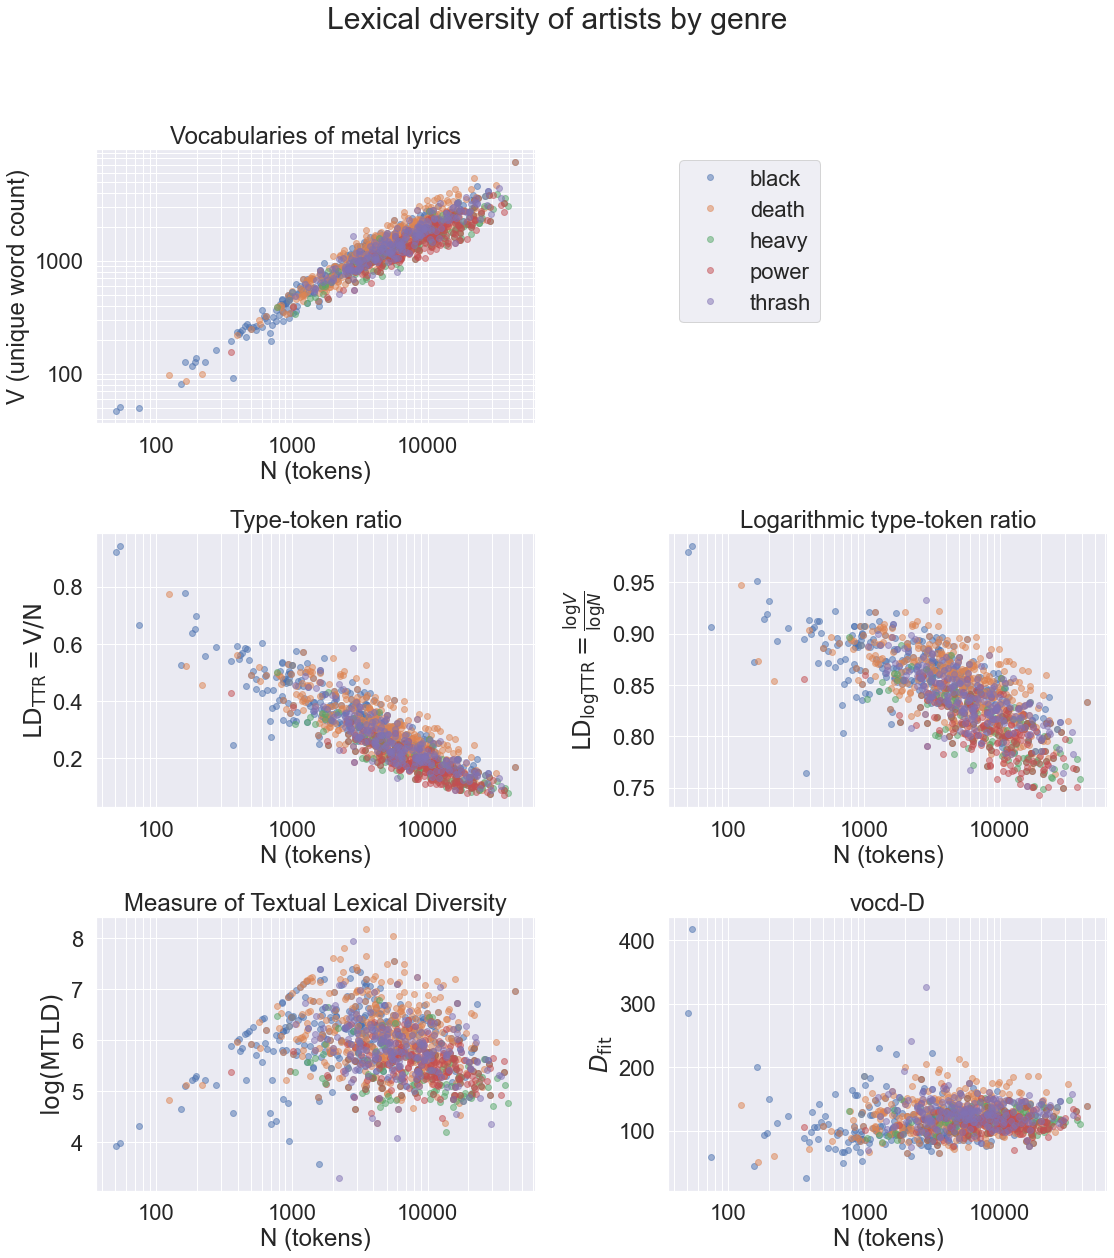

In [255]:
genres = df_bands.columns[:list(df_bands.columns).index('lyrics')]

def lexical_diversity_scatterplot(col, ax, logx=False, logy=False):
    for genre in genres:
        subset = df_bands[df_bands[genre] > 0]
        ax.plot(subset['N'], subset[col], 'o', markeredgewidth=1, alpha=0.5, label=genre)
    ax.set_xlabel("N (tokens)")
    if logx:
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(ScalarFormatter())
    if logy:
        ax.set_yscale('log')
        ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.grid(True, axis='both', which='major')
    ax.grid(True, axis='both', which='minor')
    return

fig, axes = plt.subplots(3, 2, figsize=(16, 18))
fig.suptitle("Lexical diversity of artists by genre", fontsize=30)
axes = axes.flatten()

ax = axes[0]
lexical_diversity_scatterplot('V', ax)
ax.set_xscale('log')
ax.set_yscale('log')
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.set_title("Vocabularies of metal lyrics")
ax.set_ylabel("V (unique word count)")

ax = axes[1]
ax.axis('off')
for genre in genres:
    ax.plot([], [], 'o', markeredgewidth=1, alpha=0.5, label=genre)
ax.legend(frameon=True, loc='upper left')

ax = axes[2]
lexical_diversity_scatterplot('TTR', ax, logx=True)
ax.set_title("Type-token ratio")
ax.set_ylabel("$\mathrm{LD_{TTR} = V/N}$")

ax = axes[3]
lexical_diversity_scatterplot('logTTR', ax, logx=True)
ax.set_title("Logarithmic type-token ratio")
ax.set_ylabel(r"$\mathrm{LD_{logTTR}} = \frac{\log V}{\log N}$")

ax = axes[4]
lexical_diversity_scatterplot('logmtld', ax, logx=True)
ax.set_title("Measure of Textual Lexical Diversity")
ax.set_ylabel(r"$\log(\mathrm{MTLD})$")

ax = axes[5]
lexical_diversity_scatterplot('vocdd', ax, logx=True)
ax.set_title("vocd-D")
ax.set_ylabel(r"$D_{\mathrm{fit}}$")

fig.tight_layout(rect=[0, 0, 1, 0.95])

# Violin plots with expanded genres dataset

In [253]:
df_exp = pd.read_csv('songs-1pct.csv')
df_exp_bands = get_bands(df_exp)
df_exp_bands = get_lexical_diversity(df_exp_bands)

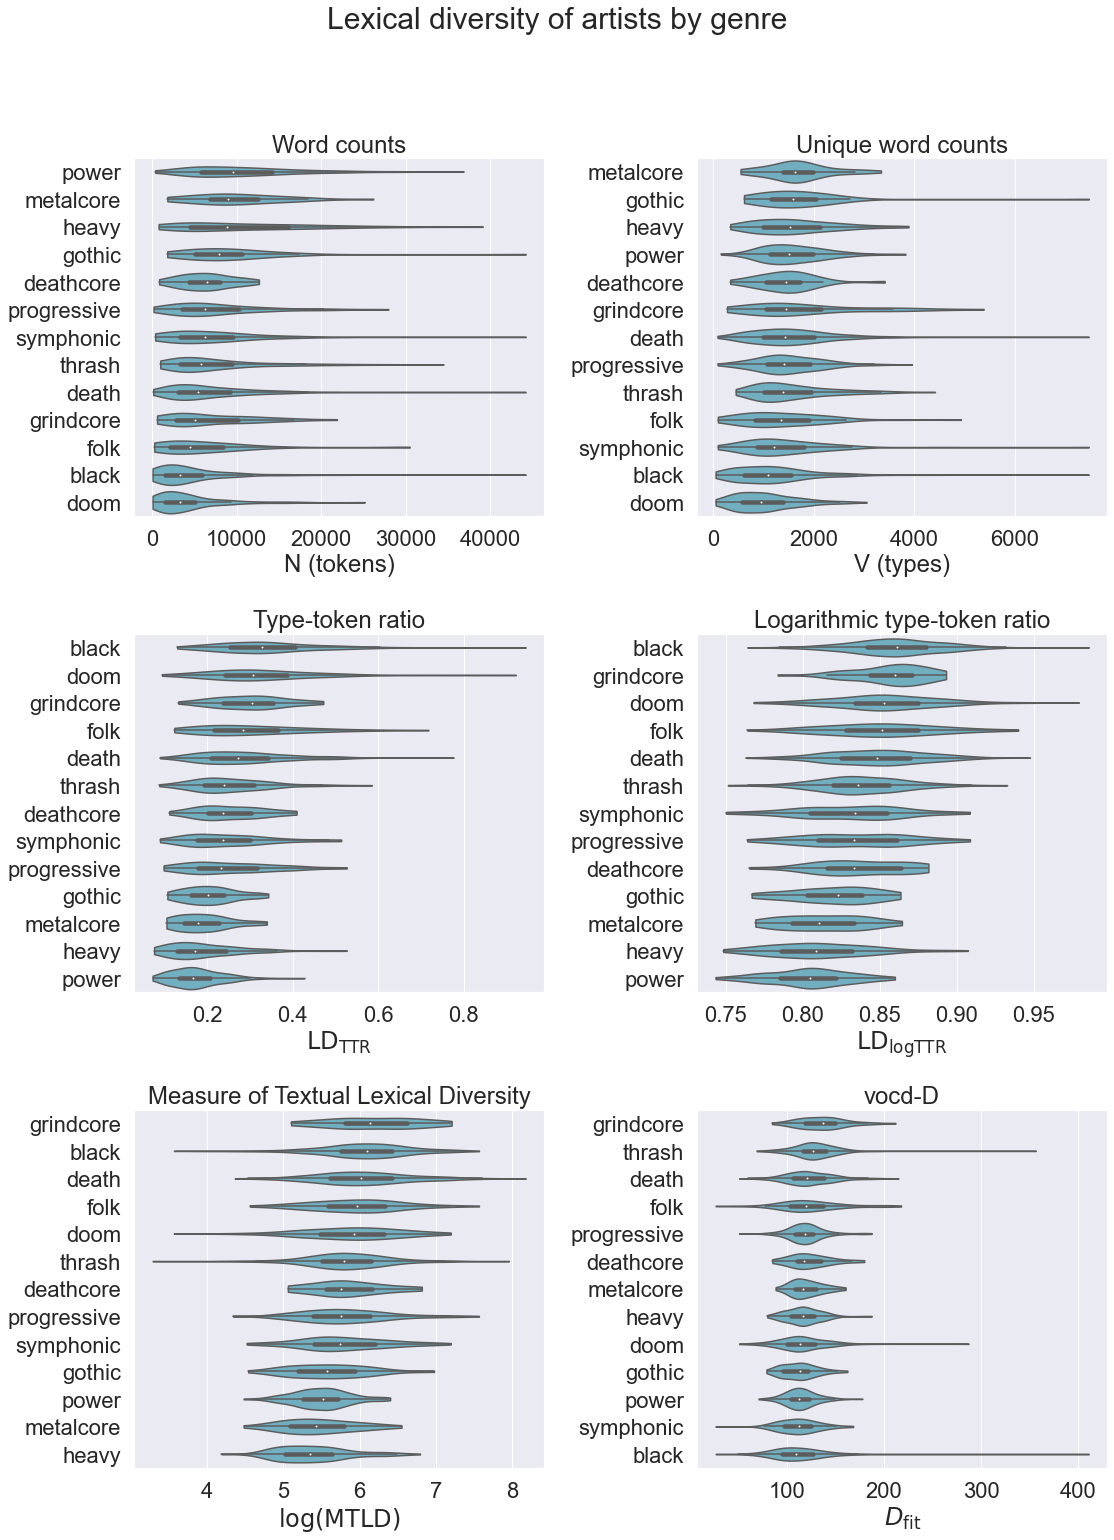

In [254]:
plot_violinplots(df_exp_bands, figsize=(16, 22))